In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools
from tqdm import tqdm

import matplotlib.ticker as mticker

In [11]:
"""
Tensorflow fashion_mnist datasets 
   @tfds :  
   TensorFlow Datasets is a collection of datasets ready to use, with TensorFlow 
   or other Python ML frameworks, such as Jax. All datasets are exposed as tf.data.Datasets ,
   enabling easy-to-use and high-performance input pipelines. To get started see the guide and our 
   list of datasets.
"""

import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

def load_datasets():
  train_data , info = tfds.load("fashion_mnist", split="train", with_info=True)
  test_data = tfds.load("fashion_mnist", split="test")
  # Fashion_mnist contains 10 labels 
  Num_of_training_data = tf.data.experimental.cardinality(train_data).numpy()
  print(Num_of_training_data)
  print(train_data)
  return train_data, test_data

"""
Normalizing the datasets 
"""

def Normalize_datasets(data):
  image = data["image"]
  # Rescaling image into a vector
  image = tf.reshape(image, [-1,])
  image = tf.cast(image,'float32')
  image = image/255.0
  return image , data["label"]  

"""
Normalizing the datasets and forming batches from original
size of 60,000 training examples and 10,000
test examples
"""

def preprocess_datasets(batch_size):
  # Getting datasets from load_datasets function
  train_data, test_data = load_datasets()
  train_data = train_data.map(Normalize_datasets)
  test_data = test_data.map(Normalize_datasets)
  # Random shuffling with default buffer size 
  train = train_data.shuffle(buffer_size=1024).batch(batch_size)
  dev = test_data.batch(batch_size)
  return train, dev




In [5]:
"""
Defining deep neural network model using keras layers
 Input : 784 neurons
 1st Deep layer : 64 neurons, relu activation
 2nd Deep layer : 64 neurons, relu activation
 Output layer : 10 neurons, softmax activation

"""

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import numpy as np

def base_model():
  inputs = tf.keras.Input(shape = (784,), name="clothing")
  x = tf.keras.layers.Dense(64, activation="relu", name="dense_1")(inputs)
  x = tf.keras.layers.Dense(64, activation="relu", name="dense_2")(x)
  outputs = tf.keras.layers.Dense(10, activation="softmax" , name="predictions")(x)
  model = tf.keras.Model(inputs=inputs,outputs=outputs)
  return model

"""
Adam optimization is a stochastic gradient descent method that is based on 
adaptive estimation of first-order and second-order moments. We used SparseCategoricalCrossentropy
since our labels are not in one-hot form.
"""

def optimizer_and_loss(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
    ):
  optimizer = tf.keras.optimizers.Adam(
      learning_rate,
      beta_1,
      beta_2,
      epsilon,
      amsgrad,
      name)
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
  return optimizer, loss_object
  


In [22]:
import tensorflow as tf

"""
Defining mertics to keep a track-record of our model accuracy during training processs
"""

def initialize_accuracy_matrics():
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  return train_acc_metric, val_acc_metric



In [26]:
import tensorflow as tf
import itertools
from tqdm import tqdm

"""
Defining training loop with tensorflow gradient tape
"""

def apply_gradient(optimizer,model,x,y,loss_object):
  """
  tf.GradientTape allows us to track TensorFlow computations and calculate
   gradients w.r.t. (with respect to) some given variables
  """

  with tf.GradientTape() as tape:
    # Forward propogation
    logits = model(x)
    loss_value = loss_object(y_true = y, y_pred = logits)
  # backward propogation i.e : Gradient computation
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients,model.trainable_weights))  
  return logits,loss_value


"""
Defining train method for one epoch
"""

def train_data_for_one_epoch(optimizer, train, model, loss_object, train_acc_metric):
  losses = []
  pbar= tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}|{n_fmt}/{total_fmt}')

  for step, (x_batch_train, y_batch_train) in enumerate(train):
    logits,loss_value = apply_gradient(optimizer,model,x_batch_train,y_batch_train,loss_object)
    losses.append(loss_value)
    train_acc_metric(y_batch_train,logits)
    pbar.set_description("Training loss for step %s: %.4f" % ( int(step), float(loss_value)))
    pbar.update()

  return losses



"""
Performing corss validation on development set after each epoch 
and calculating cross-accuracy
"""

def perform_validation(model, dev, val_acc_metric ,loss_object):
  losses = []
  for x_val,y_val in dev:
    val_logits = model(x_val)
    val_loss = loss_object(y_true = y_val, y_pred = val_logits)
    losses.append(val_loss)

    val_acc_metric(y_val,val_logits)
  return losses 


In [28]:
import numpy as np

"""
Training loop initialization
"""

def initialize_training():

  train_acc_metric, val_acc_metric = initialize_accuracy_matrics()
  optimizer,loss_object = optimizer_and_loss()
  train, dev = preprocess_datasets( 64)
  # Instance of main tensorflow model
  model = base_model()

  epochs = 10
  epoch_val_losses, epoch_train_losses = [],[]

  for epoch in range(epochs):
    print('Start of epoch %d'% (epoch,)) 

    losses_train = train_data_for_one_epoch(optimizer,train,model,loss_object, train_acc_metric)
    train_acc = train_acc_metric.result()

    losses_val = perform_validation(model, dev , val_acc_metric, loss_object)
    val_acc = val_acc_metric.result()

    losses_train_mean = np.mean(losses_train)
    losses_dev_mean = np.mean(losses_val)

    epoch_val_losses.append(losses_train_mean)
    epoch_train_losses.append(losses_dev_mean)

    print("For epoch"+str(epoch)+", Train loss is = "+str(losses_train_mean)+", Dev loss is ="+str(losses_dev_mean)+" Train accuracy is ="+str(train_acc.numpy())+", Dev accuracy is "+str(val_acc.numpy()))

    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

  return model, epoch_val_losses, epoch_train_losses, dev

model, epoch_val_losses, epoch_train_losses, dev = initialize_training()



60000
<PrefetchDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>
Start of epoch 0


Training loss for step 937: 0.4153: 100%|██████████|938/938


For epoch0, Train loss is = 0.5477903, Dev loss is =0.45410627 Train accuracy is =0.8085167, Dev accuracy is 0.8343
Start of epoch 1


Training loss for step 937: 0.6731: 100%|██████████|938/938


For epoch1, Train loss is = 0.39875722, Dev loss is =0.41549584 Train accuracy is =0.85613334, Dev accuracy is 0.8514
Start of epoch 2


Training loss for step 937: 0.1753: 100%|██████████|938/938


For epoch2, Train loss is = 0.36065698, Dev loss is =0.41272637 Train accuracy is =0.87046665, Dev accuracy is 0.8548
Start of epoch 3


Training loss for step 937: 0.1975: 100%|██████████|938/938


For epoch3, Train loss is = 0.3340827, Dev loss is =0.37297118 Train accuracy is =0.87918335, Dev accuracy is 0.8668
Start of epoch 4


Training loss for step 937: 0.2740: 100%|██████████|938/938


For epoch4, Train loss is = 0.3154151, Dev loss is =0.39066783 Train accuracy is =0.88385, Dev accuracy is 0.8634
Start of epoch 5


Training loss for step 937: 0.1931: 100%|██████████|938/938


For epoch5, Train loss is = 0.3012433, Dev loss is =0.36243865 Train accuracy is =0.8891, Dev accuracy is 0.8753
Start of epoch 6


Training loss for step 937: 0.2972: 100%|██████████|938/938


For epoch6, Train loss is = 0.2883074, Dev loss is =0.35052654 Train accuracy is =0.8936667, Dev accuracy is 0.8776
Start of epoch 7


Training loss for step 937: 0.3513: 100%|██████████|938/938


For epoch7, Train loss is = 0.27667016, Dev loss is =0.33893237 Train accuracy is =0.89846665, Dev accuracy is 0.8841
Start of epoch 8


Training loss for step 937: 0.2848: 100%|██████████|938/938


For epoch8, Train loss is = 0.26781708, Dev loss is =0.34557456 Train accuracy is =0.89996666, Dev accuracy is 0.8811
Start of epoch 9


Training loss for step 937: 0.3573: 100%|██████████|938/938


For epoch9, Train loss is = 0.25754863, Dev loss is =0.3811124 Train accuracy is =0.90435, Dev accuracy is 0.8719


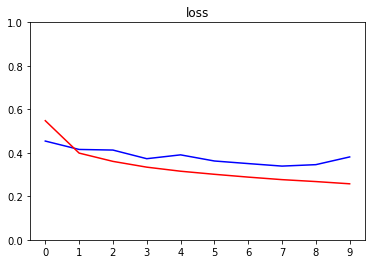

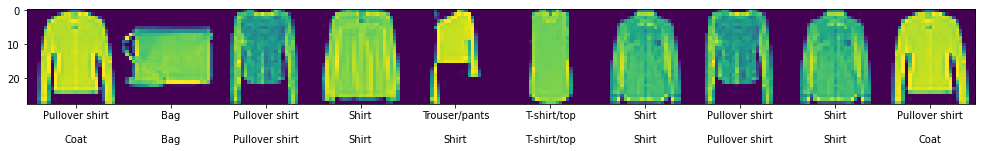

In [39]:
import numpy as np
import matplotlib.ticker as mticker
from matplotlib import pyplot as plt

def plot_metrics( train_m , val_m ,title):
  plt.title(title)
  plt.ylim(0,1.0)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_m,color="blue")
  plt.plot(val_m,color="red")


def display_image( image_to_plot, n, y_pred_label, y_real_label):
  plt.figure(figsize=(17,3)) 
  display_strings = [str(i)+"\n\n"+str(j) for i,j in zip(y_pred_label,y_real_label)]
  plt.xticks([28*x+14 for x in range(n)],display_strings )
  image = np.reshape(image_to_plot , [n,28,28])
  image = np.swapaxes( image , 0, 1)
  image = np.reshape( image, [28, 28 * n])
  plt.imshow(image)

plot_metrics(epoch_train_losses,epoch_val_losses, "loss")


def Visualize_metrice():
  # Corresponding labels for Fashion MNST datasets
  classes_name = [ "T-shirt/top","Trouser/pants", "Pullover shirt","Dress","Coat","Sandal", "Shirt", "Sneaker","Bag","Ankle boot" ]
  x_batches, y_pred_batches, y_real_batches=[],[],[]

  for x,y in dev:
    y_pred = model(x)
    y_pred_batches = y_pred.numpy()
    y_real_batches = y.numpy()
    x_batches = x.numpy()

  indexes = np.random.choice(len(y_pred_batches), size=10)
  image_to_plot = x_batches[indexes]
  y_pred_to_plot = y_pred_batches[indexes]
  y_true_to_plot = y_real_batches[indexes]
  y_pred_label = [ classes_name[np.argmax(j)] for j in y_pred_to_plot]
  y_real_label = [ classes_name[i] for i in y_true_to_plot]
  display_image( image_to_plot, 10, y_pred_label, y_real_label)

Visualize_metrice()